# LSTM

In [9]:
import numpy as np
import pandas as pd
import pymssql
import csv
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

file = pd.read_csv('C:/Users/admin/Desktop/csv/G_Data0000000683.csv')
sql_source = pd.DataFrame(file)

sql_source.CreateDate = sql_source.CreateDate.astype('datetime64')


target = pd.DataFrame(columns = ['date','use_gas_day'])
i = 0
j = 0
while i<len(sql_source)-1:
    while(i+1<len(sql_source) and sql_source.at[i,'CreateDate'].date()==sql_source.at[i+1,'CreateDate'].date()):
        i = i+1
    j = i+1
    while(j+1<len(sql_source) and sql_source.at[j,'CreateDate'].date()==sql_source.at[j+1,'CreateDate'].date()):
        j = j+1
    if(sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']<0):
        break
    if((sql_source.at[j,'CreateDate'].date()-sql_source.at[i,'CreateDate'].date()).days==1 and sql_source.at[i,'CreateDate'].hour==sql_source.at[j,'CreateDate'].hour and 30>=abs(sql_source.at[i,'CreateDate'].minute-sql_source.at[j,'CreateDate'].minute)>=0 and sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']>0):
        target = target.append([{'date':sql_source.at[j,'CreateDate'].date(),'use_gas_day':sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']}],ignore_index = True)
    i = j
###########################################
i = 1
while i<len(target)-1:
    a = target.at[i-1,'use_gas_day']
    b = target.at[i,'use_gas_day']
    c = target.at[i+1,'use_gas_day']
    A = abs(b-a)/max(a,b)
    B = abs(c-b)/max(c,b)
    if(A>0.5 and B>0.5):
        target.at[i,'use_gas_day'] = (a+c)/2
    i = i+1
    
########################################
# Covnert RangeIndex column to 时间戳Index
target = target.reset_index(drop=True).set_index('date')
target.index = pd.DatetimeIndex(target.index)
########################################
#补全日期
target = target.resample('D').mean()
target = target.fillna(target.bfill())
print(len(target))

################################
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
sca_target = target
sca_target['use_gas_day'] = scaler.fit_transform(target.iloc[:, 0:1])
print(sca_target)

1075
            use_gas_day
date                   
2018-08-28     0.000000
2018-08-29     0.000058
2018-08-30     0.000058
2018-08-31     0.023938
2018-09-01     0.023938
...                 ...
2021-08-02     0.016971
2021-08-03     0.008998
2021-08-04     0.008998
2021-08-05     0.001025
2021-08-06     0.001025

[1075 rows x 1 columns]


In [10]:
def use_gas_day_LSTM_Data_Precesing(df,timestep):    
    features = []
    labels = []
    df = np.array(df)
    date_list = []
    for i in range(timestep, len(sca_target)):
        features.append(df[i-timestep:i,:])
        labels.append(df[i, 0])
        date_list.append(target.index[i])
    features, labels = np.array(features), np.array(labels)
    features = np.reshape(features, (features.shape[0], features.shape[1], -1))
    x_train,x_test,y_train,y_test= features[:900, ],features[900:, ],labels[:900],labels[900:]
    return x_train,x_test,y_train,y_test,date_list

In [3]:
mem_days = [4]
lstm_layers = [0]
dense_layers = [1]
units = [52]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './LSTM/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}' 
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True
                )
                x_train,x_test,y_train,y_test,date_list = use_gas_day_LSTM_Data_Precesing(sca_target,the_mem_days)
                
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                
                model.add(LSTM(the_units,input_shape = (x_train.shape[1], x_train.shape[2]),activation='relu'))
                model.add(Dropout(0.1))
#                 for i in range(the_lstm_layers):
#                     model.add(LSTM(the_units,activation='relu',return_sequences=True))
#                     model.add(Dropout(0.1))
                for i in range(the_dense_layers):
                    model.add(Dense(the_units))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(x_train,y_train,batch_size = 32,epochs = 100,shuffle = True,validation_data=(x_test,y_test),callbacks = [checkpoint])
                
        

Epoch 1/300
29/29 [==============================] - 1s 10ms/step - loss: 0.0559 - mape: 68.0509 - val_loss: 0.0240 - val_mape: 521.6310
INFO:tensorflow:Assets written to: ./LSTM\521.63_01_men_4_lstm_0_dense_1_unit_52\assets
Epoch 2/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0136 - mape: 45.3594 - val_loss: 0.0067 - val_mape: 202.3868
INFO:tensorflow:Assets written to: ./LSTM\202.39_02_men_4_lstm_0_dense_1_unit_52\assets
Epoch 3/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0077 - mape: 20.1640 - val_loss: 0.0049 - val_mape: 82.7471
INFO:tensorflow:Assets written to: ./LSTM\82.75_03_men_4_lstm_0_dense_1_unit_52\assets
Epoch 4/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0074 - mape: 18.4128 - val_loss: 0.0050 - val_mape: 84.6158
Epoch 5/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0072 - mape: 18.3217 - val_loss: 0.0048 - val_mape: 80.3188
INFO:tensorflow:Assets written to: ./LSTM\80.32_05_men_4_ls

Epoch 117/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - mape: 15.7921 - val_loss: 0.0046 - val_mape: 75.6770
Epoch 118/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 14.6126 - val_loss: 0.0045 - val_mape: 85.8338
Epoch 119/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 15.2314 - val_loss: 0.0049 - val_mape: 116.8431
Epoch 120/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 14.5990 - val_loss: 0.0048 - val_mape: 101.8336
Epoch 121/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 15.0537 - val_loss: 0.0049 - val_mape: 93.5696
Epoch 122/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0064 - mape: 15.5746 - val_loss: 0.0046 - val_mape: 101.8153
Epoch 123/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0062 - mape: 16.1509 - val_loss: 0.0045 - val_mape: 92.4459
Epoch 124/300
29/29 [=================

Epoch 175/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0053 - mape: 13.9333 - val_loss: 0.0045 - val_mape: 68.2950
Epoch 176/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0059 - mape: 14.6634 - val_loss: 0.0045 - val_mape: 81.2295
Epoch 177/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 13.9671 - val_loss: 0.0043 - val_mape: 67.7445
Epoch 178/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 13.2638 - val_loss: 0.0042 - val_mape: 52.3864
Epoch 179/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - mape: 16.3555 - val_loss: 0.0043 - val_mape: 57.2167
Epoch 180/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 14.0357 - val_loss: 0.0053 - val_mape: 99.2225
Epoch 181/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 15.8510 - val_loss: 0.0044 - val_mape: 58.8335
Epoch 182/300
29/29 [====================

Epoch 234/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0056 - mape: 14.8092 - val_loss: 0.0046 - val_mape: 71.1916
Epoch 235/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 14.3102 - val_loss: 0.0042 - val_mape: 39.9325
Epoch 236/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0054 - mape: 14.0650 - val_loss: 0.0045 - val_mape: 71.5763
Epoch 237/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0058 - mape: 13.2575 - val_loss: 0.0046 - val_mape: 87.6078
Epoch 238/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0055 - mape: 14.1883 - val_loss: 0.0046 - val_mape: 78.2955
Epoch 239/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 13.8856 - val_loss: 0.0051 - val_mape: 99.3594
Epoch 240/300
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - mape: 14.6955 - val_loss: 0.0042 - val_mape: 58.3774
Epoch 241/300
29/29 [====================

In [11]:
from tensorflow.keras.models import load_model
best_model = load_model('./LSTM/22.44_251_men_4_lstm_0_dense_1_unit_52')

predicted_train = best_model.predict(x_train)
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = best_model.predict(x_test)
predicted_test = scaler.inverse_transform(predicted_test)
real_train=scaler.inverse_transform(np.reshape(y_train,(-1,1)))
real_test=scaler.inverse_transform(np.reshape(y_test,(-1,1)))

best_model.summary()
best_model.evaluate(x_test,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 52)                11232     
_________________________________________________________________
dropout (Dropout)            (None, 52)                0         
_________________________________________________________________
dense (Dense)                (None, 52)                2756      
_________________________________________________________________
dropout_1 (Dropout)          (None, 52)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 53        
Total params: 14,041
Trainable params: 14,041
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 2ms/step - loss: 0.0043 - mape: 22.4356


[0.004295022692531347, 22.435571670532227]

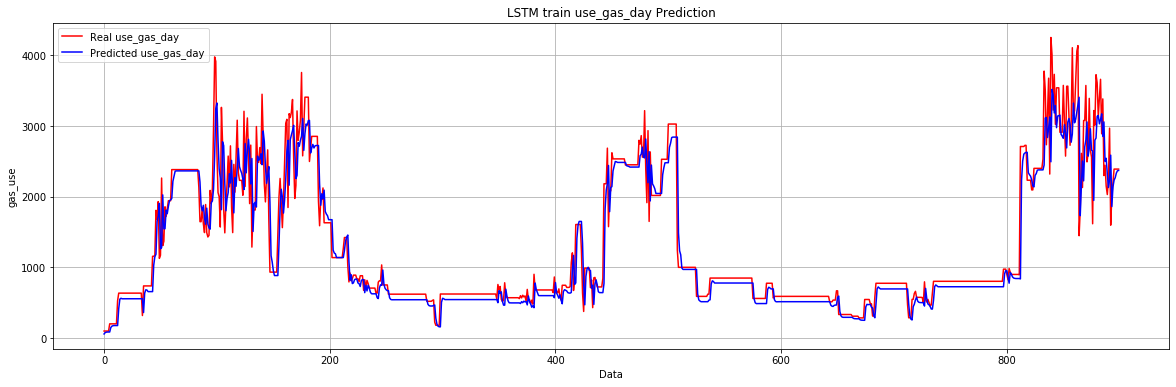

train_mean: 1302.100167
LSTM模型的均方误差是: 93635.228878
LSTM模型的均方根误差是: 305.998740
LSTM模型的平均绝对误差是: 175.074762
LSTM模型的R-squared是: 0.893140


In [12]:
# Visualising the train results
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()
x = date_list[:450]
ax.plot(real_train, color = 'red', label = 'Real use_gas_day')
ax.plot(predicted_train, color = 'blue', label = 'Predicted use_gas_day')
ax.set_title('LSTM train use_gas_day Prediction')
ax.set_xlabel('Data')
ax.set_ylabel('gas_use')
ax.legend()
ax.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from numpy import *
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
train_mean = mean(real_train)
mse = mean_squared_error(predicted_train, real_train)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_train, real_train))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_train, real_train)

r2=r2_score(real_train,predicted_train)

print('train_mean: %.6f' % train_mean)
print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)

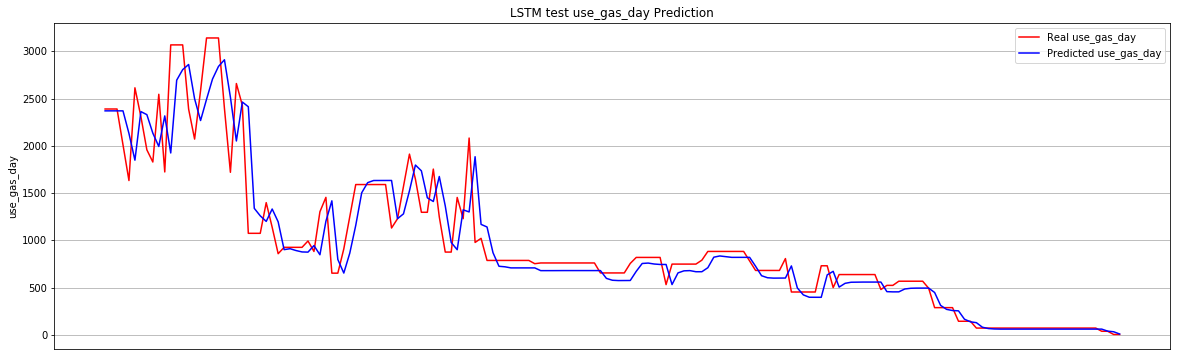

test_mean: 959.823138
LSTM模型的均方误差是: 77601.699268
LSTM模型的均方根误差是: 278.570816
LSTM模型的平均绝对误差是: 169.863428
LSTM模型的R-squared是: 0.861858


In [13]:
# Visualising the test results
import matplotlib.dates as mdates
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()
x = date_list[500:]
ax.plot(real_test, color = 'red', label = 'Real use_gas_day')
ax.plot(predicted_test, color = 'blue', label = 'Predicted use_gas_day')
ax.set_title('LSTM test use_gas_day Prediction')
ax.set_ylabel('use_gas_day')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()
ax.grid(True)
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from numpy import *
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
test_mean = mean(real_test)
mse = mean_squared_error(real_test,predicted_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(real_test,predicted_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_test, real_test)

r2=r2_score(real_test,predicted_test)

acc = (test_mean-mae)/test_mean
print('test_mean: %.6f' % test_mean)
print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)